<a href="https://colab.research.google.com/github/Rodisolomon/RAG_GPT2/blob/main/rag_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## install

In [ ]:
%%capture
!pip install --upgrade torch torchvision
!pip install torch numpy transformers datasets tiktoken wandb tqdm
!python3 -m pip install memray
!pip install deepspeed
!pip install mpi4py
import deepspeed
import memray
import mpi4py
import subprocess

In [ ]:
# Run this then press "Restart Runtime"
%%capture
!pip install datasets apache-beam
!pip install transformers torch rank_bm25 pinecone-client

In [ ]:
%%capture
!pip install multiprocess==0.70.15
!pip install mwparserfromhell

In [ ]:
!pip install -qU \
  langchain==0.0.162 \
  openai==0.27.7 \
  tiktoken==0.4.0 \
  "pinecone-client[grpc]"==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.9/770.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
apache-beam 2.52.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.52.0 requires p

In [ ]:
%%capture
!pip install pinecone_text \
            bert-score

In [ ]:
from tqdm.auto import tqdm
from uuid import uuid4
from datasets import load_dataset, concatenate_datasets
from transformers import BertTokenizer, BertModel
from transformers import BartTokenizer, BartForConditionalGeneration

import torch
import numpy as np
import pinecone
from uuid import uuid4
from collections import Counter
from pinecone_text.sparse import BM25Encoder
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from bert_score import score


In [ ]:
#load dataset
wikipedia = load_dataset("wikipedia", "20220301.simple", split="train")
api_key = '84255b91-3148-4add-a7b2-088319f0aa8c'
env = 'us-west1-gcp'

In [ ]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize the BERT model
model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## proof of concept (ignore this section)
basically we need a retriever (query encoder + document index) with a pretrained model (NanoGPT). We use RAG-Sequence / token model to do so

Longchain model:
https://github.com/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/05-langchain-retrieval-augmentation.ipynb

pip bug ref:
https://colab.research.google.com/drive/1PTeGlshamFcJZix_GiS3vMXX_YzAhGv0?usp=sharing#scrollTo=50T95MMgjPIm

### actual implementation

1. create embedding (pre-trained BERT (Bidirectional Encoder Representations from Transformers) Base Document Encoder)

2. create indexing

3. create vector database (using pinecone to handle vector database) https://www.datacamp.com/tutorial/mastering-vector-databases-with-pinecone-tutorial

In [ ]:
# print(wikipedia)
# wikipedia.features
# print(wikipedia.num_rows)
# print(wikipedia[0]["id"], wikipedia[0]["url"], wikipedia[0]["title"])

#### tokenize

In [ ]:
#ABANDONED
#TRY with splitter + encode
#embedding with RoBERTa optimized with more data, larger mini-batches, and more training steps.

# def chunk_text(text, chunk_size):
#     # Tokenize the text into words (or subwords)
#     tokens = tokenizer.tokenize(text)
#     # Chunk tokens
#     chunked_tokens = [tokens[i:i + chunk_size] for i in range(0, len(tokens), chunk_size)]
#     return chunked_tokens

# # Assuming `chunk_size` is 512 - [CLS] and [SEP] tokens
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaModel.from_pretrained('roberta-base')

# sample_text = wikipedia[0]["text"]
# chunked_texts = chunk_text(sample_text, 510)

# model_outputs = []
# length = 3 #wikipedia.num_rows
# for i in range(0, length):
#   chunked_texts = chunk_text(wikipedia[i]["text"], 510)
#   for chunk in chunked_texts:
#       chunk = ['[CLS]'] + chunk + ['[SEP]']
#       input_ids = tokenizer.convert_tokens_to_ids(chunk) # Convert tokens to input IDs
#       input_ids_tensor = torch.tensor([input_ids])
#       with torch.no_grad():
#           output = model(input_ids_tensor)
#           model_outputs.append(output)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# print(sample_text[:200])
# print(chunked_texts[:10])
# print(chunked_texts[0][0])

In [ ]:
# #get dimension
# with torch.no_grad():
#     output = model(input_ids_tensor)
#     # Get the last hidden state tensor, which has the shape
#     last_hidden_state = output.last_hidden_state
#     # Append just the last hidden state tensor to model_outputs
#     model_outputs.append(last_hidden_state)
#     # Print the shape of the last hidden state tensor
#     print(last_hidden_state.shape)
# print(len(model_outputs))

torch.Size([1, 222, 768])


#### vector db

In [ ]:
index_name = "rag-nanogpt"
api_key = "cb314c17-4344-4bd3-be90-389290b42904"
environment = 'gcp-starter'

In [ ]:
#initiate/restart vector database
pinecone.init(api_key=api_key, environment = environment)
if index_name not in pinecone.list_indexes():
    pinecone.create_index(
        name=index_name,
        metric='euclidean',
        dimension=last_hidden_state.shape[-1]
    )
index = pinecone.GRPCIndex(index_name)
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.99996,
 'namespaces': {'': {'vector_count': 99996}},
 'total_vector_count': 99996}

In [ ]:
#downgrade protobuf to avoid conflict
!pip uninstall protobuf
!pip install --no-cache-dir protobuf==3.20.3

Found existing installation: protobuf 3.19.6
Uninstalling protobuf-3.19.6:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/google/protobuf/*
    /usr/local/lib/python3.10/dist-packages/protobuf-3.19.6-py3.10-nspkg.pth
    /usr/local/lib/python3.10/dist-packages/protobuf-3.19.6.dist-info/*
Proceed (Y/n)? Y
  Successfully uninstalled protobuf-3.19.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.52.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.


In [ ]:
# Process and embed texts
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
batch_limit = 100  # Batch size for processing and upserting
texts = []
ids = []
metas = []

for i, record in enumerate(tqdm(wikipedia)):
    chunked_texts, ori_texts = chunk_text(record["text"], 510)

    for j in range(len(chunked_texts)):
        chunk, ori = chunked_texts[j], ori_texts[j]
        metadata = {
          'wiki-id': str(record['id']),
          'source': record['url'],
          'title': record['title'],
          'original_text': ori
        }
        # Add the special tokens
        chunk = ['[CLS]'] + chunk + ['[SEP]']
        # Convert tokens to input IDs
        input_ids = tokenizer.convert_tokens_to_ids(chunk)
        # Convert to tensor
        input_ids_tensor = torch.tensor([input_ids])
        # Embed the text
        with torch.no_grad():
            outputs = model(input_ids_tensor)
            embeds = outputs.last_hidden_state[:, 0, :].numpy()
            unique_id = str(uuid4())
            texts.extend(embeds)
            ids.append(unique_id)
            metas.append(metadata)
            if len(texts) >= batch_limit:
                vectors = [{'id': a, 'values': b, 'metadata': c} for a, b, c in zip(ids, texts, metas)]
                index.upsert(vectors=vectors)
                texts, ids, metas = [], [], []


# Upsert any remaining texts after the loop
if texts:
    vectors = [{'id': a, 'values': b, 'metadata': c} for a, b, c in zip(ids, texts, metas)]
    index.upsert(vectors=vectors)

  0%|          | 0/205328 [00:00<?, ?it/s]

PineconeException: ignored

### Quick retrieving test w vector db (retriever is simple dot product not DPR)

pinecone: https://app.pinecone.io/organizations/-Nj0Xfo8kkjF3UA6zm3s/projects/gcp-starter:ky9mkeq/indexes/rag-nanogpt/browser

BERT: https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d

In [ ]:
# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# takes a text and returns the embedding
def get_roberta_embedding(query_text):
    input_ids = tokenizer.encode(query_text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(input_ids)
    embeddings = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return embeddings

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#easy test
query = "when did President Franklin D. Roosevelt die?"
encoded_text = get_roberta_embedding(query)
matches = index.query(
  vector=encoded_text,
  top_k=3,
  include_values=True,
  include_metadata=True
)["matches"]

In [ ]:
for i in range(len(matches)):
  print(matches[i]["metadata"])

{'title': 'April', 'source': 'https://simple.wikipedia.org/wiki/April', 'original_text': " Roman Calendar, before the start of the new year was put to January 1.\n\nQuite a few festivals are held in this month. In many Southeast Asian cultures, new year is celebrated in this month (including Songkran). In Western Christianity, Easter can be celebrated on a Sunday between March 22 and April 25. In Orthodox Christianity, it can fall between April 4 and May 8. At the end of the month, Central and Northern European cultures celebrate Walpurgis Night on April 30, marking the transition from winter into summer.\n\nApril in poetry \nPoets use April to mean the end of winter. For example: April showers bring May flowers.\n\nEvents in April\n\nFixed Events \n\n April 1 - April Fools' Day\n April 1 - Islamic Republic Day (Iran)\n April 2 - International Children's Book Day\n April 2 - Thai Heritage and Conservation Day\n April 2 - World Autism Awareness Day\n April 2 - Malvinas Day (Argentina)\n

## Dense retriever BERT, sparse BM25, and mixed version of it
https://towardsdatascience.com/understanding-dense-passage-retrieval-dpr-system-bce5aee4fd40

pinecone has dot product implemented, while acccording to paper we want $e^{d(z)^{T}q(x)}$

### modularized method and code

1.   https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/semantic-search/sparse/bm25/bm25-vector-generation.ipynb#scrollTo=KR75WORb7kga
2.   https://docs.pinecone.io/docs/hybrid-search
3.   https://www.pinecone.io/learn/hybrid-search-intro/



In [ ]:
def initiate_restart_pinecone(index_name, api_key, env, metric='dotproduct', dimension=768):
    '''
    initiate a vector db in pinecone if doesn't have one, otherwise restart it and make it ready
    args (all available in pinecone):
    --------------------------
    index_name: name of the db
    api_key: api key
    env: environment name
    '''
    pinecone.init(api_key=api_key, env = env)
    if index_name not in pinecone.list_indexes():
        pinecone.create_index(
            name=index_name,
            metric=metric,
            dimension=dimension
        )
    index = pinecone.GRPCIndex(index_name)
    index.describe_index_stats()
    return index

In [ ]:
%%capture
def preprocess_chunk_text(text, chunk_size, tokenizer=None):
    '''
    Tokenize the text into words (or subwords), add [SEP] and [CLS] for BERT, also return
    '''
    if tokenizer is None:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    sentences = text.split('. ')
    bm25 = BM25Encoder()
    bm25.fit(sentences)
    # Add [CLS] at the beginning and [SEP] after each sentence
    tokens = ['[CLS]']
    for sentence in sentences:
        tokens += tokenizer.tokenize(sentence) + ['[SEP]']
    # Initialize the list to hold chunks of token IDs and original texts
    chunked_tokens = []
    ori_texts = []
    # Create chunks of tokens and decode them to get the original texts
    for i in range(0, len(tokens), chunk_size):
        chunk = tokens[i:i + chunk_size]

        input_ids = tokenizer.convert_tokens_to_ids(chunk)
        ori_text = tokenizer.decode(input_ids, skip_special_tokens=True)
        chunked_tokens.append(input_ids)
        ori_texts.append(ori_text)

    return chunked_tokens, ori_texts, bm25

### implementation

In [ ]:
# # Dataset setup
# wikipedia = load_dataset("wikipedia", "20220301.simple", split="train")

# # Pinecone setup
# api_key = '84255b91-3148-4add-a7b2-088319f0aa8c'
# env = 'us-west1-gcp'
# index_name = 'wiki-db-2'
# index = initiate_restart_pinecone(index_name=index_name,
#                                   api_key=api_key,
#                                   env=env)

# #downgrade protobuf to avoid conflict
# #!pip uninstall protobuf
# #!pip install --no-cache-dir protobuf==3.20.3

# # Initialize BERT
# #tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# #model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# %%capture
# from threading import excepthook
# # Process and embed texts
# batch_limit = 20  # Batch size for processing and upserting
# dense, sparse, ids, metas = [], [], [], []

# for i, record in enumerate(tqdm(wikipedia)):
#     if i < 160000:
#         continue
#     if i > 200000:
#         break
#     # Tokenize the text into chunks of 510 tokens
#     chunked_texts, ori_texts, bm25 = preprocess_chunk_text(record["text"], 510)
#     # Process and embed each chunk of the text separately
#     for j in range(len(chunked_texts)):
#         chunk, ori = chunked_texts[j], ori_texts[j]
#         metadata = {
#           'wiki-id': str(record['id']),
#           'source': record['url'],
#           'title': record['title'],
#           'original_text': ori
#         }
#         # Convert to tensor
#         input_ids_tensor = torch.tensor([chunk])
#         # Embed the text
#         with torch.no_grad():
#             outputs = model(input_ids_tensor)
#             embeds = outputs.last_hidden_state[:, 0, :].numpy()
#             sparse_embeds = bm25.encode_documents(ori) #{indices:[], values:[]}
#             unique_id = str(uuid4())
#             dense.extend(embeds)
#             sparse.append(sparse_embeds)
#             ids.append(unique_id)
#             metas.append(metadata)
#             print(len(dense))
#             if len(dense) >= batch_limit:
#                 try:
#                     vectors = [{'id': a, 'values': b, 'sparse_values': c, 'metadata': d}
#                             for a, b, c, d in zip(ids, dense, sparse, metas)]
#                     index.upsert(vectors=vectors)
#                     print("GOOO")
#                     dense, sparse, ids, metas = [], [], [], []
#                 except:
#                     dense, sparse, ids, metas = [], [], [], []
#                     print("ERRRR")

# # Upsert any remaining texts after the loop
# if dense:
#     vectors = [{'id': a, 'values': b, 'sparse_values': c, 'metadata': d}
#                for a, b, c, d in zip(ids, dense, sparse, metas)]
#     index.upsert(vectors=vectors)

### retriever

In [ ]:
# takes a text and returns the embedding
def get_bert_embedding(query_text):
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    input_ids = bert_tokenizer.encode(query_text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(input_ids)
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return embedding

#return a dict #{indices:[], values:[]}
def get_bm25_embedding(query_text):
    bm25 = BM25Encoder()
    bm25.fit(query_text)
    embedding = bm25.encode_documents(query_text)
    return embedding

In [ ]:
def hybrid_scale(dense, sparse, alpha: float):
    # check alpha value is in range
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse


def hybrid_query(index, question, top_k, alpha):
   # convert the question into a sparse vector
   sparse_vec = get_bm25_embedding(question)
   # convert the question into a dense vector
   dense_vec = get_bert_embedding(question)
   # scale alpha with hybrid_scale
   dense_vec, sparse_vec = hybrid_scale(
      dense_vec, sparse_vec, alpha
   )
   # query pinecone with the query parameters
   result = index.query(
      vector=dense_vec,
      sparse_vector=sparse_vec,
      top_k=top_k,
      include_metadata=True
   )
   # return search results as json
   return result

In [ ]:
# result = hybrid_query(index, question="what's april?", top_k=3, alpha=0.3)
# print(result)

### hook up w nanogpt (ignore)

paper use BART, we'll use NanoGPT as the purpose for this project

In [ ]:
# import io
# import time
# from google.colab import drive
# drive.mount('/content/drive')
# ! rm -rf deep_learning_sys_lab
# ! git clone https://github.com/karpathy/nanoGPT.git

In [ ]:
# !cd nanoGPT && python sample.py \
#     --init_from=gpt2-xl \
#     --start="What is the answer to life, the universe, and everything?" \
#     --num_samples=5 --max_new_tokens=100

### GPT-2 Performance

#### Cross-Entropy Loss


In [ ]:
# print(wikipedia[int(1e5)])

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
sample_question = "what is 'about last night'? "

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

result = hybrid_query(index, question=sample_question, top_k=2, alpha=0.3)

#print(result)

NameError: ignored

In [ ]:
context = ''
for data in result['matches']:
    context += data['metadata']['original_text']
extended_sample_question = sample_question + "[context: " + context + " ]"
#print(extended_sample_question)

In [ ]:
# Load pre-trained GPT-2 model and tokenizer
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [ ]:
#with RAG
# Example text
inputs = tokenizer(extended_sample_question, return_tensors="pt", truncation=True, max_length=512)

# Forward pass, get logits
outputs = model(**inputs)
logits = outputs.logits

# Shift logits and labels for calculating loss (ignore the last prediction)
shifted_logits = logits[..., :-1, :].contiguous()
shifted_labels = inputs["input_ids"][..., 1:].contiguous()

# Define loss function
loss_fct = torch.nn.CrossEntropyLoss()

# Flatten the tokens
loss = loss_fct(shifted_logits.view(-1, shifted_logits.size(-1)), shifted_labels.view(-1))

print("Cross-Entropy Loss:", loss.item())

In [ ]:
#without RAG
# Example text
inputs = tokenizer(sample_question, return_tensors="pt")

# Forward pass, get logits
outputs = model(**inputs)
logits = outputs.logits

# Shift logits and labels for calculating loss (ignore the last prediction)
shifted_logits = logits[..., :-1, :].contiguous()
shifted_labels = inputs["input_ids"][..., 1:].contiguous()

# Define loss function
loss_fct = torch.nn.CrossEntropyLoss()

# Flatten the tokens
loss = loss_fct(shifted_logits.view(-1, shifted_logits.size(-1)), shifted_labels.view(-1))

print("Cross-Entropy Loss:", loss.item())


#### perplexity score

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

def calculate_perplexity(model, text, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

    # Pass the input through the model
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        log_likelihood = outputs.loss

    # Calculate perplexity
    perplexity = torch.exp(log_likelihood / inputs["input_ids"].shape[1])
    return perplexity.item()

# Example usage
sample_question = "what is 'about last night'? "
perplexity = calculate_perplexity(model, sample_question, tokenizer) # Assuming you have a tokenizer
print(f'Perplexity: {perplexity}')

# Example usage
sample_question = "what is 'about last night'? "
perplexity = calculate_perplexity(model, extended_sample_question, tokenizer) # Assuming you have a tokenizer
print(f'Perplexity with RAG: {perplexity}')

## COMPARISON
1. comparing DPR with BM25

  documents: https://www.researchgate.net/figure/Comparison-of-BM25-and-DPR-with-regard-to-recallk-on-the-full-German-Wikipedia_fig2_351105102

  https://arxiv.org/pdf/2009.08553.pdf

2. used astrophysics/biology database to test with domain-specific questions

  bio: https://huggingface.co/datasets/HydraLM/biology_dataset_alpaca
  
  astr: https://arxiv.org/pdf/2112.00590.pdf (paper) https://huggingface.co/adsabs/astroBERT (huggingface)
  
3. after retrieving relevant data, concatenation or separate input (not possible in GPT so we explicitly define sth like "Questions: the_original_question. Context: context_retrived_from")
4. use google search to compare with RAG


### modularized code

In [ ]:
def calculate_cross_entropy_loss(model, text, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

    # Forward pass, get logits
    outputs = model(**inputs)
    logits = outputs.logits

    # Shift logits and labels for calculating loss (ignore the last prediction)
    shifted_logits = logits[..., :-1, :].contiguous()
    shifted_labels = inputs["input_ids"][..., 1:].contiguous()

    # Define loss function
    loss_fct = torch.nn.CrossEntropyLoss()

    # Flatten the tokens and calculate loss
    loss = loss_fct(shifted_logits.view(-1, shifted_logits.size(-1)), shifted_labels.view(-1))

    return loss.item()

# calculate_cross_entropy_loss(model, extended_sample_question, GPT2Tokenizer.from_pretrained('gpt2'))

In [ ]:
def calculate_perplexity(model, text, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

    # Pass the input through the model
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        log_likelihood = outputs.loss

    # Calculate perplexity
    perplexity = torch.exp(log_likelihood / inputs["input_ids"].shape[1])
    return perplexity.item()

In [ ]:
import random

def random_indices_from_ranges(ranges, num_samples):
    # Flatten the ranges into a single list of indices
    all_indices = []
    for start, end in ranges:
        all_indices.extend(range(start, end + 1))

    # Randomly select the desired number of indices from the list
    if num_samples > len(all_indices):
        raise ValueError("Number of samples requested exceeds the total number of indices available")

    return random.sample(all_indices, num_samples)

# # Example usage
# ranges = [(0, 50), (70, 100)]  # Define your ranges
# num_samples = 3                # Define how many samples you want
# random_indices = random_indices_from_ranges(ranges, num_samples)

# print(random_indices)

In [ ]:
def calculate_similarity(
    model,
    text,
    tokenizer,
    answer,
    num_return_sequences=1,
    num_beams=1,
    max_length=50
    ): #beam must be larger than search sequence
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    input_ids = inputs["input_ids"]
    # Forward pass, get logits
    outputs = model.generate(input_ids,
                             max_length=max_length+len(input_ids[0]),
                             num_return_sequences=num_return_sequences,
                             num_beams=num_beams,
                             early_stopping=True,)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_text_without_input = generated_text[len(text):]
    P, R, F1 = score([generated_text_without_input], [answer], lang='en')

    print(f"Precision: {P.item()}, Recall: {R.item()}, F1 Score: {F1.item()}")
    print(generated_text_without_input)
    return P, R, F1



In [ ]:
# [context: fruit is food that's sweet]
calculate_similarity(gpt2_model,
                     "what's an apple? explain",
                     gpt2_tokenizer,
                     "an apple is a fruit which is sweet",
                     num_return_sequences=5,
                     num_beams=10)

Precision: 0.777700662612915, Recall: 0.8326993584632874, F1 Score: 0.8042608499526978
 it to me."

"It's an apple."

"It's an apple."

"It's an apple."

"It's an apple."

"It's an apple."

"It's an


(tensor([0.7777]), tensor([0.8327]), tensor([0.8043]))

In [ ]:
calculate_similarity(gpt2_model,
                     "context: fruit is food that's sweet. what's an apple? explain",
                     gpt2_tokenizer,
                     "an apple is a fruit which is sweet",
                     num_return_sequences=5,
                     num_beams=10)

Precision: 0.8311432600021362, Recall: 0.8918740153312683, F1 Score: 0.8604384064674377
ertext: fruit is food that's sweet. what's an apple? explainertext: fruit is food that's sweet. what's an apple? explainertext: fruit is food that's sweet. what's an apple? explainertext


(tensor([0.8311]), tensor([0.8919]), tensor([0.8604]))

In [ ]:
calculate_similarity(gpt2_model,
                     "what's an apple? explain! context: fruit is food that's sweet",
                     gpt2_tokenizer,
                     "an apple is a fruit which is sweet",
                     num_return_sequences=5,
                     num_beams=10)

Precision: 0.8336633443832397, Recall: 0.8931832313537598, F1 Score: 0.8623975515365601
, juicy, and delicious.

What's an apple? explain! context: fruit is food that's sweet, juicy, and delicious.

What's an apple? explain! context: fruit is food that's sweet, juicy, and


(tensor([0.8337]), tensor([0.8932]), tensor([0.8624]))

Precision (P): Measures how much of the generated text was relevant or similar to the reference text. Higher precision means more of the generated text was relevant.

Recall (R): Assesses how much of the reference text was captured by the generated text. Higher recall means more of the reference content was reflected in the generated text.

F1 Score: Harmonic mean of precision and recall, providing a balance between them. It's a more comprehensive measure of how well the generated text matches the reference text.

In [ ]:
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2-xl')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
bert_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
bert_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')


In [ ]:
def truncate_to_last_tokens(tokenizer, text, max_length): #leave the question (in the end)
    # Tokenize the text
    tokens = tokenizer.encode(text, add_special_tokens=True)

    # Truncate to the last 'max_length' tokens
    if len(tokens) > max_length:
        truncated_tokens = tokens[-max_length:]
        return truncated_tokens
    return tokens

In [ ]:
##so that we can effectively summarized retrieved text
def summarize(text,
              bert_model,
              bert_tokenizer,
              max_length=200):
    print(f"before summarize text is {text}")
    inputs = bert_tokenizer([text], max_length=512, return_tensors='pt', truncation=True)
    summary_ids = bert_model.generate(inputs['input_ids'], num_beams=4, max_length=max_length, early_stopping=True)
    return bert_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [ ]:
text = "In information retrieval, Okapi BM25 (BM is an abbreviation of best matching) is a ranking function used by search engines to estimate the relevance of documents to a given search query. It is based on the probabilistic retrieval framework developed in the 1970s and 1980s by Stephen E. Robertson, Karen Spärck Jones, and others.The name of the actual ranking function is BM25. The fuller name, Okapi BM25, includes the name of the first system to use it, which was the Okapi information retrieval system, implemented at London's City University[1] in the 1980s and 1990s. BM25 and its newer variants, e.g. BM25F (a version of BM25 that can take document structure and anchor text into account), represent TF-IDF-like retrieval functions used in document retrieval.[2]"
print(summarize(text))

Okapi BM25 is a ranking function used by search engines to estimate the relevance of documents to a given search query. It is based on the probabilistic retrieval framework developed in the 1970s and 1980s by Stephen E. Robertson, Karen Spärck Jones, and others.


In [355]:
##wrong operation
def no_evaluation(model,
               tokenizer,
               test_set,
               bart_tokenizer,
               bart_model,
               RAG=False,
               max_length=200,
               num_return_sequences=2,
               num_beams=2,
               alpha=0.5,
               top_k=2
               ):
    perplexities, Ps, Rs, F1s, cross_entropy_losses = 0, 0, 0, 0, 0
    index1 = initiate_restart_pinecone(index_name='wiki-db', api_key=api_key, env=env)
    index2 = initiate_restart_pinecone(index_name='wiki-db-2', api_key=api_key, env=env)
    test_set_len = len(test_set)  # Pre-calculate length of test set

    for item in test_set:
        question = f". Based on that, tell me what/who is {item['title']}?"
        answer = item['text']

        context = ''
        if RAG:
            for query_result in [hybrid_query(index1, item['title'], top_k, alpha), hybrid_query(index2, item['title'], top_k, alpha)]:
                context_parts = [data['metadata']['original_text'] for data in query_result['matches']]
                context += ' '.join(context_parts)
            summarized_context = summarize(context, bart_model, bart_tokenizer)
            final_question = f"context: {summarized_context} {question}"
        else:
            final_question = question
        print(final_question)
        input_ids = tokenizer.encode(final_question, return_tensors='pt')
        # input_ids = truncate_to_last_tokens(tokenizer, final_question, max_length=200)
        # input_ids = torch.tensor([input_ids])
        # input_ids = input_ids[:, :max_length] if len(input_ids[0]) >= model.config.n_ctx else input_ids
        outputs = model.generate(input_ids, max_length=max_length, num_return_sequences=num_return_sequences, num_beams=num_beams)
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_text_without_input = generated_text[len(final_question):]

        print(f"generated text is {generated_text_without_input}")

        if not generated_text_without_input.strip():
            print("Warning: The generated text is empty.")
            test_set_len -= 1

        P, R, F1 = score([generated_text_without_input], [answer], lang='en')
        perplexity = calculate_perplexity(model, final_question, tokenizer)
        cross_entropy_loss = calculate_cross_entropy_loss(model, final_question, tokenizer)

        perplexities += perplexity
        Ps += P.item()
        Rs += R.item()
        F1s += F1.item()
        cross_entropy_losses += cross_entropy_loss

    return [perplexities / test_set_len, Ps / test_set_len, Rs / test_set_len, F1s / test_set_len, cross_entropy_losses / test_set_len]


In [380]:
top_k = 2
def evaluation(model,
               tokenizer,
               test_set,
               bart_tokenizer,
               bart_model,
               RAG=False,
               max_length=200,
               num_return_sequences=2,
               num_beams=2,
               alpha=0.5,
               top_k=1):
    perplexities, Ps, Rs, F1s, cross_entropy_losses = 0, 0, 0, 0, 0
    index1 = initiate_restart_pinecone(index_name='wiki-db', api_key=api_key, env=env)
    index2 = initiate_restart_pinecone(index_name='wiki-db-2', api_key=api_key, env=env)
    test_set_len = len(test_set)  # Pre-calculate length of test set

    for item in test_set:
        question = f". Based on that, tell me what/who is {item['title']}?"
        answer = item['text']

        context = ''
        if RAG:
            for query_result in [hybrid_query(index1, question, top_k, alpha), hybrid_query(index2, question, top_k, alpha)]:
                context_parts = [data['metadata']['original_text'] for data in query_result['matches']]
                context += ' '.join(context_parts)
            summarized_context = summarize(context, bart_model, bart_tokenizer)
            final_question = f"context: {summarized_context} {question}"
        else:
            final_question = question

        print(f"final question is {final_question}")
        input_ids = tokenizer.encode(final_question, return_tensors='pt')
        # input_ids = truncate_to_last_tokens(tokenizer, final_question, max_length=200)
        # input_ids = torch.tensor([input_ids])
        # input_ids = input_ids[:, :max_length] if len(input_ids[0]) >= model.config.n_ctx else input_ids
        print(len(input_ids[0]))
        outputs = model.generate(input_ids, max_length=max_length, num_return_sequences=num_return_sequences, num_beams=num_beams)
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_text_without_input = generated_text[len(final_question):]

        print(f"generated text is {generated_text}")

        if not generated_text_without_input.strip():
            print("Warning: The generated text is empty.")
            test_set_len -= 1

        P, R, F1 = score([generated_text_without_input], [answer], lang='en')
        perplexity = calculate_perplexity(model, final_question, tokenizer)
        cross_entropy_loss = calculate_cross_entropy_loss(model, final_question, tokenizer)

        perplexities += perplexity
        Ps += P.item()
        Rs += R.item()
        F1s += F1.item()
        cross_entropy_losses += cross_entropy_loss

    return [perplexities / test_set_len, Ps / test_set_len, Rs / test_set_len, F1s / test_set_len, cross_entropy_losses / test_set_len]

### wikipedia

#### sparse dense retriever

In [ ]:
#different alpha level, pick the most optimal one to go to the next section
#alpha = 0 & 1 for sparse and dense
#no RAG as baseline
wikipedia = load_dataset("wikipedia", "20220301.simple", split="train")
wikipedia_test = concatenate_datasets([wikipedia.select(range(75000, 100000)), wikipedia.select(range(195000, 205000))])
print(wikipedia_test)

# Select the samples from wikipedia_test
test_subset = wikipedia_test.select(random_indices_from_ranges([(0, 35000)],500))
#print(test_subset)
print(gpt2_model.config.n_ctx)
test_set = wikipedia_test.select(random_indices_from_ranges([(0, 35000)],10))



Dataset({
    features: ['id', 'url', 'title', 'text'],
    num_rows: 35000
})
1024


In [ ]:
#sparse
sparse_level = np.round(np.linspace(0, 1, 12), 3) #alpha
print(sparse_level)

[0.    0.091 0.182 0.273 0.364 0.455 0.545 0.636 0.727 0.818 0.909 1.   ]


In [ ]:
result = []
for a in [1, 0.5, 0]:
    print(f"alpha level is {a}")
    result.append(
        evaluation(
            gpt2_model,
            gpt2_tokenizer,
            test_set,
            bert_tokenizer,
            bert_model,
            RAG = True,
            alpha = a))
    print(result[-1])


alpha level is 1


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

context: messina ( ; ) is a province in the autonomous region of sicily. People may have started using the compound word, living room, in the early twentieth century. " the waste land " is a poem by t. s eliot it was first published in 1922. . Based on that, tell me what/who is Salem, Sweden?
73
generated text is context: messina ( ; ) is a province in the autonomous region of sicily. People may have started using the compound word, living room, in the early twentieth century. " the waste land " is a poem by t. s eliot it was first published in 1922.. Based on that, tell me what/who is Salem, Sweden?

Salem, Sweden, is a city in Sweden. It is the capital of the province of Sverige. It is located in the north of the country. It is the largest city in the province of Sverige. It has a population of about 1.5 million people. It is the second largest city in the province of Sverige. It is also the largest city in Sweden.

Salem, Sweden, is a city in Sweden. It is the capital of the provinc

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

context:  lady godiva ( ; about 980 – 1067 ) was an anglo - saxon noblewoman. She was married to earl leofric and frequently donated to the church. There are legends that say that she rode naked through the streets of coventry in england. . Based on that, tell me what/who is Pannotia?
74
generated text is context:  lady godiva ( ; about 980 – 1067 ) was an anglo - saxon noblewoman. She was married to earl leofric and frequently donated to the church. There are legends that say that she rode naked through the streets of coventry in england.. Based on that, tell me what/who is Pannotia?

Pannotia is the name of a goddess in the Greek pantheon. She was the daughter of the god Zeus and the goddess Demeter. She was the goddess of the harvest and fertility. She was also the goddess of the harvest and fertility. She was the daughter of the god Zeus and the goddess Demeter. She was the goddess of the harvest and fertility. She was also the goddess of the harvest and fertility. She was the daug

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

context: ". sacha baron cohen used his persona ali g (whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates black culture. . Based on that, tell me what/who is Kitty Wells?
104
generated text is context: ". sacha baron cohen used his persona ali g (whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates black culture.. Based on that, tell me what/who is Kitty Wells?

"Kitty Wells" is a fictional character created by a white person for the purpose of making fun of black culture.



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

context: ". sacha baron cohen used his persona ali g ( whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates various aspects of the black life. . Based on that, tell me what/who is Jason Sudeikis?
111
generated text is context: ". sacha baron cohen used his persona ali g ( whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates various aspects of the black life.. Based on that, tell me what/who is Jason Sudeikis? he is a white actor who plays a black character in the film "the bl

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

context: r. e. m is an american rock band it was formed in athens, georgia in 1980. The lead singer of the band was michael stipe. They were one of the most important rock bands in the campus radio movement they became successful internationally in 1987, when they released the songs, " the one i love " and " it's the end of the world as we know it ( and i feel fine ) " . Based on that, tell me what/who is Eddy Arnold?
106
generated text is context: r. e. m is an american rock band it was formed in athens, georgia in 1980. The lead singer of the band was michael stipe. They were one of the most important rock bands in the campus radio movement they became successful internationally in 1987, when they released the songs, " the one i love " and " it's the end of the world as we know it ( and i feel fine ) ". Based on that, tell me what/who is Eddy Arnold?

Eddy Arnold was a student at the University of Georgia in the early 1980s. He was a member of the band, " The One i Love " and was the

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

context: " soldier " is an r & b / hip hop song written by beyonce knowles, kelly rowland, michelle williams, rich harrison, sean garrett, t. i., and lil wayne for destiny's child's fourth studio album, destiny fulfilled ( 2004 ) it was produced by knowles and harrison and released as the album's second single in fall 2004. It reached number 3 in australia and the united states it became the group's tenth and final consecutive top 10 hit in the us. . Based on that, tell me what/who is Josh Turner?
127
generated text is context: " soldier " is an r & b / hip hop song written by beyonce knowles, kelly rowland, michelle williams, rich harrison, sean garrett, t. i., and lil wayne for destiny's child's fourth studio album, destiny fulfilled ( 2004 ) it was produced by knowles and harrison and released as the album's second single in fall 2004. It reached number 3 in australia and the united states it became the group's tenth and final consecutive top 10 hit in the us.. Based on that, tell m

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

context: messina ( ; ) is a province in the autonomous region of sicily. sacha baron cohen used his persona ali g to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates black culture. . Based on that, tell me what/who is Dealey Plaza?
108
generated text is context: messina ( ; ) is a province in the autonomous region of sicily. sacha baron cohen used his persona ali g to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates black culture.. Based on that, tell me what/who is Dealey Plaza?

Anonymous 05/11/15 (Mon) 11:02:40 AM No. 98912 >>98898

I'm not sure if this is the right pl

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

context: number theory is a part of mathematics. It explains what some types of numbers are, what properties they have, and ways that they can be useful. A well - known application of number theory is encrypted messaging ( encryption) data compression also makes use of the field. topics in number theory are : prime numbers factorization matrix important theorems in number Theory are : chinese remainder theorem fundamental theorem of arithmetic fermat's last theorem. . Based on that, tell me what/who is Dawn Wells?
103
generated text is context: number theory is a part of mathematics. It explains what some types of numbers are, what properties they have, and ways that they can be useful. A well - known application of number theory is encrypted messaging ( encryption) data compression also makes use of the field. topics in number theory are : prime numbers factorization matrix important theorems in number Theory are : chinese remainder theorem fundamental theorem of arithmetic fermat's l

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

context:  lady godiva ( ; about 980 – 1067 ) was an anglo - saxon noblewoman. She was married to earl leofric and frequently donated to the church. There are legends that say that she rode naked through the streets of coventry in england. . Based on that, tell me what/who is Dora Cadavid?
75
generated text is context:  lady godiva ( ; about 980 – 1067 ) was an anglo - saxon noblewoman. She was married to earl leofric and frequently donated to the church. There are legends that say that she rode naked through the streets of coventry in england.. Based on that, tell me what/who is Dora Cadavid? Dora Cadavid is a character in the book series The Wheel of Time by Robert Jordan and Brandon Sanderson. She is the daughter of the king of the Aiel, and the wife of the king of the Seanchan. She is also the mother of Rand al'Thor. She is also the mother of Moiraine Damodred. She is also the mother of Perrin Aybara. She is also the mother of Elayne Trakand. She is also the mother of Elayne and Nyn

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

context: doctrine of ma'at is represented in the declarations to rekhti - merti - f - ent - ma'At and the 42 negative affirmations listed in the papyrus of ani. verily i have not done iniquity to mankind. 2 not have i done harm unto animals. . Based on that, tell me what/who is Yohkoh?
81
generated text is context: doctrine of ma'at is represented in the declarations to rekhti - merti - f - ent - ma'At and the 42 negative affirmations listed in the papyrus of ani. verily i have not done iniquity to mankind. 2 not have i done harm unto animals.. Based on that, tell me what/who is Yohkoh?

Yohkoh is the name of the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the
[1.34354338

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

context: messina ( ; ) is a province in the autonomous region of sicily. People may have started using the compound word, living room, in the early twentieth century. " the waste land " is a poem by t. s eliot it was first published in 1922. . Based on that, tell me what/who is Salem, Sweden?
73
generated text is context: messina ( ; ) is a province in the autonomous region of sicily. People may have started using the compound word, living room, in the early twentieth century. " the waste land " is a poem by t. s eliot it was first published in 1922.. Based on that, tell me what/who is Salem, Sweden?

Salem, Sweden, is a city in Sweden. It is the capital of the province of Sverige. It is located in the north of the country. It is the largest city in the province of Sverige. It has a population of about 1.5 million people. It is the second largest city in the province of Sverige. It is also the largest city in Sweden.

Salem, Sweden, is a city in Sweden. It is the capital of the provinc

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

context:  lady godiva ( ; about 980 – 1067 ) was an anglo - saxon noblewoman. She was married to earl leofric and frequently donated to the church. There are legends that say that she rode naked through the streets of coventry in england. . Based on that, tell me what/who is Pannotia?
74
generated text is context:  lady godiva ( ; about 980 – 1067 ) was an anglo - saxon noblewoman. She was married to earl leofric and frequently donated to the church. There are legends that say that she rode naked through the streets of coventry in england.. Based on that, tell me what/who is Pannotia?

Pannotia is the name of a goddess in the Greek pantheon. She was the daughter of the god Zeus and the goddess Demeter. She was the goddess of the harvest and fertility. She was also the goddess of the harvest and fertility. She was the daughter of the god Zeus and the goddess Demeter. She was the goddess of the harvest and fertility. She was also the goddess of the harvest and fertility. She was the daug

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

context: ". sacha baron cohen used his persona ali g (whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates black culture. . Based on that, tell me what/who is Kitty Wells?
104
generated text is context: ". sacha baron cohen used his persona ali g (whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates black culture.. Based on that, tell me what/who is Kitty Wells?

"Kitty Wells" is a fictional character created by a white person for the purpose of making fun of black culture.



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

context: ". sacha baron cohen used his persona ali g ( whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates various aspects of the black life. . Based on that, tell me what/who is Jason Sudeikis?
111
generated text is context: ". sacha baron cohen used his persona ali g ( whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates various aspects of the black life.. Based on that, tell me what/who is Jason Sudeikis? he is a white actor who plays a black character in the film "the bl

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

context: r. e. m is an american rock band it was formed in athens, georgia in 1980. The lead singer of the band was michael stipe. They were one of the most important rock bands in the campus radio movement they became successful internationally in 1987, when they released the songs, " the one i love " and " it's the end of the world as we know it ( and i feel fine ) " . Based on that, tell me what/who is Eddy Arnold?
106
generated text is context: r. e. m is an american rock band it was formed in athens, georgia in 1980. The lead singer of the band was michael stipe. They were one of the most important rock bands in the campus radio movement they became successful internationally in 1987, when they released the songs, " the one i love " and " it's the end of the world as we know it ( and i feel fine ) ". Based on that, tell me what/who is Eddy Arnold?

Eddy Arnold was a student at the University of Georgia in the early 1980s. He was a member of the band, " The One i Love " and was the

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

context: " soldier " is an r & b / hip hop song written by beyonce knowles, kelly rowland, michelle williams, rich harrison, sean garrett, t. i., and lil wayne for destiny's child's fourth studio album, destiny fulfilled ( 2004 ) it was produced by knowles and harrison and released as the album's second single in fall 2004. It reached number 3 in australia and the united states it became the group's tenth and final consecutive top 10 hit in the us. . Based on that, tell me what/who is Josh Turner?
127
generated text is context: " soldier " is an r & b / hip hop song written by beyonce knowles, kelly rowland, michelle williams, rich harrison, sean garrett, t. i., and lil wayne for destiny's child's fourth studio album, destiny fulfilled ( 2004 ) it was produced by knowles and harrison and released as the album's second single in fall 2004. It reached number 3 in australia and the united states it became the group's tenth and final consecutive top 10 hit in the us.. Based on that, tell m

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

context: messina ( ; ) is a province in the autonomous region of sicily. sacha baron cohen used his persona ali g to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates black culture. . Based on that, tell me what/who is Dealey Plaza?
108
generated text is context: messina ( ; ) is a province in the autonomous region of sicily. sacha baron cohen used his persona ali g to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates black culture.. Based on that, tell me what/who is Dealey Plaza?

Anonymous 05/11/15 (Mon) 11:02:40 AM No. 98912 >>98898

I'm not sure if this is the right pl

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

context: number theory is a part of mathematics. It explains what some types of numbers are, what properties they have, and ways that they can be useful. A well - known application of number theory is encrypted messaging ( encryption) data compression also makes use of the field. topics in number theory are : prime numbers factorization matrix important theorems in number Theory are : chinese remainder theorem fundamental theorem of arithmetic fermat's last theorem. . Based on that, tell me what/who is Dawn Wells?
103
generated text is context: number theory is a part of mathematics. It explains what some types of numbers are, what properties they have, and ways that they can be useful. A well - known application of number theory is encrypted messaging ( encryption) data compression also makes use of the field. topics in number theory are : prime numbers factorization matrix important theorems in number Theory are : chinese remainder theorem fundamental theorem of arithmetic fermat's l

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

context:  lady godiva ( ; about 980 – 1067 ) was an anglo - saxon noblewoman. She was married to earl leofric and frequently donated to the church. There are legends that say that she rode naked through the streets of coventry in england. . Based on that, tell me what/who is Dora Cadavid?
75
generated text is context:  lady godiva ( ; about 980 – 1067 ) was an anglo - saxon noblewoman. She was married to earl leofric and frequently donated to the church. There are legends that say that she rode naked through the streets of coventry in england.. Based on that, tell me what/who is Dora Cadavid? Dora Cadavid is a character in the book series The Wheel of Time by Robert Jordan and Brandon Sanderson. She is the daughter of the king of the Aiel, and the wife of the king of the Seanchan. She is also the mother of Rand al'Thor. She is also the mother of Moiraine Damodred. She is also the mother of Perrin Aybara. She is also the mother of Elayne Trakand. She is also the mother of Elayne and Nyn

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

context: doctrine of ma'at is represented in the declarations to rekhti - merti - f - ent - ma'At and the 42 negative affirmations listed in the papyrus of ani. verily i have not done iniquity to mankind. 2 not have i done harm unto animals. . Based on that, tell me what/who is Yohkoh?
81
generated text is context: doctrine of ma'at is represented in the declarations to rekhti - merti - f - ent - ma'At and the 42 negative affirmations listed in the papyrus of ani. verily i have not done iniquity to mankind. 2 not have i done harm unto animals.. Based on that, tell me what/who is Yohkoh?

Yohkoh is the name of the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the
[1.34354338

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

context:  andromeda may refer to : andromeda ( mythology), a woman in trouble in greek mythology and Andromeda ( constellation), a group of stars the andromeda galaxy hms and Andromeda, one of several warships of the royal navy in arts and literature. andromeda is an abbreviation for beneath the sky, an american metalcore band, a global consulting firm headquartered in stockholm, sweden. . Based on that, tell me what/who is Salem, Sweden?
98
generated text is context:  andromeda may refer to : andromeda ( mythology), a woman in trouble in greek mythology and Andromeda ( constellation), a group of stars the andromeda galaxy hms and Andromeda, one of several warships of the royal navy in arts and literature. andromeda is an abbreviation for beneath the sky, an american metalcore band, a global consulting firm headquartered in stockholm, sweden.. Based on that, tell me what/who is Salem, Sweden? andromeda ( mythology), a woman in trouble in greek mythology and Andromeda ( constellation), 

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

context: in downtown phoenix, arizona phoenix coyotes, an nhl hockey team based in phoenix. phoenix finance, attempted to enter formula 1 in 2002, after buying some of the assets of the defunct prost team.phoenix ( plant), genus of trees within the palm family arecaceae ( including the date palm ) phoenix ( chicken), a breed of chicken from japan companies phoenix ag, an industrial company based in hamburg. . Based on that, tell me what/who is Pannotia?
110
generated text is context: in downtown phoenix, arizona phoenix coyotes, an nhl hockey team based in phoenix. phoenix finance, attempted to enter formula 1 in 2002, after buying some of the assets of the defunct prost team.phoenix ( plant), genus of trees within the palm family arecaceae ( including the date palm ) phoenix ( chicken), a breed of chicken from japan companies phoenix ag, an industrial company based in hamburg.. Based on that, tell me what/who is Pannotia? phoenix, a city in japan. phoenix, a city in japan. phoenix, a 

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

context: kitty hawk is a genus of trees, populus, which includes the cottonwoods, poplars, and aspensthe flags of the cities of the united states exhibit a wide variety of regional influences and local histories, as well as widely different styles and design principles. many flags of floridian cities feature their city seal on a saltire. . Based on that, tell me what/who is Kitty Wells?
88
generated text is context: kitty hawk is a genus of trees, populus, which includes the cottonwoods, poplars, and aspensthe flags of the cities of the united states exhibit a wide variety of regional influences and local histories, as well as widely different styles and design principles. many flags of floridian cities feature their city seal on a saltire.. Based on that, tell me what/who is Kitty Wells?

Kitty Wells is a fictional character from the comic book series of the same name. She is a fictional character from the comic book series of the same name. She is a fictional character from the comic

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

context: first base, or 1b, is the first of four positions on a baseball diamond, in baseball. canadian may refer to : something of, from, or related to canada, a country. canadians are people identified with the country of canada. . Based on that, tell me what/who is Jason Sudeikis?
73
generated text is context: first base, or 1b, is the first of four positions on a baseball diamond, in baseball. canadian may refer to : something of, from, or related to canada, a country. canadians are people identified with the country of canada.. Based on that, tell me what/who is Jason Sudeikis?

. Based on that, tell me what/who is Jason Sudeikis? canadian can refer to : something of, from, or related to canada, a country. canadians are people identified with the country of canada.. Based on that, tell me what/who is Jason Sudeikis?

canadian can refer to : something of, from, or related to canada, a country. canadians are people identified with the country of canada.. Based on that, tell me what/

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

context: First base, or 1b, is the first of four positions on a baseball diamond, in baseball. First basemen are not listed at the hall of fame as such, but played half their career at first base. Current first basemen include: Lance berkman wilson, dan brouthers, ryan garko, jimmie foxx, hank greenberg, johnny mize, eddie murray. . Based on that, tell me what/who is Eddy Arnold?
106
generated text is context: First base, or 1b, is the first of four positions on a baseball diamond, in baseball. First basemen are not listed at the hall of fame as such, but played half their career at first base. Current first basemen include: Lance berkman wilson, dan brouthers, ryan garko, jimmie foxx, hank greenberg, johnny mize, eddie murray.. Based on that, tell me what/who is Eddy Arnold?

. Based on that, tell me what/who is Eddy Arnold? What is the name of the song that is played at the end of every episode of the show?

What is the name of the song that is played at the end of every episode of t

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

context: in downtown phoenix, arizona phoenix coyotes, an nhl hockey team based in phoenix. phoenix finance, attempted to enter formula 1 in 2002, after buying some of the assets of the defunct prost team.phoenix ( plant), genus of trees within the palm family arecaceae ( including the date palm ) phoenix ( chicken), a breed of chicken from japan companies phoenix ag, an industrial company based in hamburg. . Based on that, tell me what/who is Josh Turner?
109
generated text is context: in downtown phoenix, arizona phoenix coyotes, an nhl hockey team based in phoenix. phoenix finance, attempted to enter formula 1 in 2002, after buying some of the assets of the defunct prost team.phoenix ( plant), genus of trees within the palm family arecaceae ( including the date palm ) phoenix ( chicken), a breed of chicken from japan companies phoenix ag, an industrial company based in hamburg.. Based on that, tell me what/who is Josh Turner? phoenix, a city in the state of california. phoenix, a ci

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

context: The word toll has several meanings. It is sometimes used as a synonym for tariff a fee charged to use some roads and bridges toll road, a road for which road usage tolls are charged toll plaza, a facility where Tolls are collected, on modern toll roads, tunnels, and bridges. toll bridge, a bridge for which Road Usage Tolls Are Charged toll tunnel, a tunnel for whichRoad usage TollsAre Charged. electronic toll collection, aims to eliminate the delay on toll roads by collecting tolls electronically. shadow toll, payments made by government to the private sector operator of a road based on the number of vehicles using the road road toll. . Based on that, tell me what/who is Dealey Plaza?
151
generated text is context: The word toll has several meanings. It is sometimes used as a synonym for tariff a fee charged to use some roads and bridges toll road, a road for which road usage tolls are charged toll plaza, a facility where Tolls are collected, on modern toll roads, tunnels, and

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

context: Don't tell me is a 2004 song by avril lavigne. It is from her album under my skin on april 27 2004, it was released as the first single off of that album. The song did well on charts, climbing to number twenty - two in the united states, at number ten in australia, and at number six in spain. . Based on that, tell me what/who is Dawn Wells?
90
generated text is context: Don't tell me is a 2004 song by avril lavigne. It is from her album under my skin on april 27 2004, it was released as the first single off of that album. The song did well on charts, climbing to number twenty - two in the united states, at number ten in australia, and at number six in spain.. Based on that, tell me what/who is Dawn Wells?

Answer: Dawn Wells is a singer/songwriter/producer/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/songwriter/song

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

context: in downtown phoenix, arizona phoenix coyotes, an nhl hockey team based in phoenix. phoenix finance, attempted to enter formula 1 in 2002, after buying some of the assets of the defunct prost team.phoenix ( plant), genus of trees within the palm family arecaceae ( including the date palm ) phoenix ( chicken), a breed of chicken from japan companies phoenix ag, an industrial company based in hamburg. . Based on that, tell me what/who is Dora Cadavid?
111
generated text is context: in downtown phoenix, arizona phoenix coyotes, an nhl hockey team based in phoenix. phoenix finance, attempted to enter formula 1 in 2002, after buying some of the assets of the defunct prost team.phoenix ( plant), genus of trees within the palm family arecaceae ( including the date palm ) phoenix ( chicken), a breed of chicken from japan companies phoenix ag, an industrial company based in hamburg.. Based on that, tell me what/who is Dora Cadavid? phoenix, a city in the state of phoenix, az. phoenix, a

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

context: in downtown phoenix, arizona phoenix coyotes, an nhl hockey team based in phoenix. phoenix finance, attempted to enter formula 1 in 2002, after buying some of the assets of the defunct prost team.phoenix ( plant), genus of trees within the palm family arecaceae ( including the date palm ) phoenix ( chicken), a breed of chicken from japan companies phoenix ag, an industrial company based in hamburg. . Based on that, tell me what/who is Yohkoh?
111
generated text is context: in downtown phoenix, arizona phoenix coyotes, an nhl hockey team based in phoenix. phoenix finance, attempted to enter formula 1 in 2002, after buying some of the assets of the defunct prost team.phoenix ( plant), genus of trees within the palm family arecaceae ( including the date palm ) phoenix ( chicken), a breed of chicken from japan companies phoenix ag, an industrial company based in hamburg.. Based on that, tell me what/who is Yohkoh? phoenix, a city in japan. phoenix, a city in japan. phoenix, a city

In [ ]:
# result
# (1)   [1.3435433864593507, 0.8004051983356476, 0.793505048751831, 0.7967294096946717, 4.418436741828918]
# (0.5) [1.3435433864593507, 0.8004051983356476, 0.793505048751831, 0.7967294096946717, 4.418436741828918]
# (0.3) [1.3435433864593507, 0.7995506405830384, 0.793585604429245, 0.7963416516780853, 4.418436741828918]
# (0)   [1.3435433864593507, 0.7877365708351135, 0.7846350789070129, 0.7858580410480499, 4.418436741828918]
# (no rag) [1.3435433864593507, 0.7866969466209411, 0.7901839554309845, 0.7882905721664428, 4.418436741828918]



In [ ]:
result.append(
    evaluation(
        gpt2_model,
        gpt2_tokenizer,
        test_set,
        bert_tokenizer,
        bert_model,
        RAG = False))
print(result[-1])

. Based on that, tell me what/who is Salem, Sweden?
15
generated text is . Based on that, tell me what/who is Salem, Sweden?

A: Salem is a city in Sweden.

Q: What is the name of the city in Sweden?

A: Stockholm.

Q: What is the name of the city in Sweden?

A: Gothenburg.

Q: What is the name of the city in Sweden?

A: Malmö.

Q: What is the name of the city in Sweden?

A: Gothenburg.

Q: What is the name of the city in Sweden?

A: Malmö.

Q: What is the name of the city in Sweden?

A: Gothenburg.

Q: What is the name of the city in Sweden?

A: Malmö.

Q: What is the name of the city in Sweden?

A: Gothenburg.
. Based on that, tell me what/who is Pannotia?
15
generated text is . Based on that, tell me what/who is Pannotia?

A: Pannotia is the name of the goddess of the sea. She is the daughter of the sea god Poseidon and the sea nymph Euryale.

Q: What is the origin of the name "Poseidon"?

A: Poseidon is the Greek god of the sea.

Q: What is the origin of the name "Euryale"?

A: Eur

In [ ]:
result.append(
    evaluation(
        gpt2_model,
        gpt2_tokenizer,
        test_set,
        bert_tokenizer,
        bert_model,
        RAG = True,
        alpha = 0.3))
print(result[-1])

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

context: messina ( ; ) is a province in the autonomous region of sicily. People may have started using the compound word, living room, in the early twentieth century. " the waste land " is a poem by t. s eliot it was first published in 1922. . Based on that, tell me what/who is Salem, Sweden?
73
generated text is context: messina ( ; ) is a province in the autonomous region of sicily. People may have started using the compound word, living room, in the early twentieth century. " the waste land " is a poem by t. s eliot it was first published in 1922.. Based on that, tell me what/who is Salem, Sweden?

Salem, Sweden, is a city in Sweden. It is the capital of the province of Sverige. It is located in the north of the country. It is the largest city in the province of Sverige. It has a population of about 1.5 million people. It is the second largest city in the province of Sverige. It is also the largest city in Sweden.

Salem, Sweden, is a city in Sweden. It is the capital of the provinc

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

context:  lady godiva ( ; about 980 – 1067 ) was an anglo - saxon noblewoman. She was married to earl leofric and frequently donated to the church. There are legends that say that she rode naked through the streets of coventry in england. . Based on that, tell me what/who is Pannotia?
74
generated text is context:  lady godiva ( ; about 980 – 1067 ) was an anglo - saxon noblewoman. She was married to earl leofric and frequently donated to the church. There are legends that say that she rode naked through the streets of coventry in england.. Based on that, tell me what/who is Pannotia?

Pannotia is the name of a goddess in the Greek pantheon. She was the daughter of the god Zeus and the goddess Demeter. She was the goddess of the harvest and fertility. She was also the goddess of the harvest and fertility. She was the daughter of the god Zeus and the goddess Demeter. She was the goddess of the harvest and fertility. She was also the goddess of the harvest and fertility. She was the daug

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

context: ". sacha baron cohen used his persona ali g (whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates black culture. . Based on that, tell me what/who is Kitty Wells?
104
generated text is context: ". sacha baron cohen used his persona ali g (whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates black culture.. Based on that, tell me what/who is Kitty Wells?

"Kitty Wells" is a fictional character created by a white person for the purpose of making fun of black culture.



  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

context: ". sacha baron cohen used his persona ali g ( whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates various aspects of the black life. . Based on that, tell me what/who is Jason Sudeikis?
111
generated text is context: ". sacha baron cohen used his persona ali g ( whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates various aspects of the black life.. Based on that, tell me what/who is Jason Sudeikis? he is a white actor who plays a black character in the film "the bl

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

context: r. e. m is an american rock band it was formed in athens, georgia in 1980. The lead singer of the band was michael stipe. They were one of the most important rock bands in the campus radio movement they became successful internationally in 1987, when they released the songs, " the one i love " and " it's the end of the world as we know it ( and i feel fine ) " . Based on that, tell me what/who is Eddy Arnold?
106
generated text is context: r. e. m is an american rock band it was formed in athens, georgia in 1980. The lead singer of the band was michael stipe. They were one of the most important rock bands in the campus radio movement they became successful internationally in 1987, when they released the songs, " the one i love " and " it's the end of the world as we know it ( and i feel fine ) ". Based on that, tell me what/who is Eddy Arnold?

Eddy Arnold was a student at the University of Georgia in the early 1980s. He was a member of the band, " The One i Love " and was the

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

context: " soldier " is an r & b / hip hop song written by beyonce knowles, kelly rowland, michelle williams, rich harrison, sean garrett, t. i., and lil wayne for destiny's child's fourth studio album, destiny fulfilled ( 2004 ) it was produced by knowles and harrison and released as the album's second single in fall 2004. It reached number 3 in australia and the united states it became the group's tenth and final consecutive top 10 hit in the us. . Based on that, tell me what/who is Josh Turner?
127
generated text is context: " soldier " is an r & b / hip hop song written by beyonce knowles, kelly rowland, michelle williams, rich harrison, sean garrett, t. i., and lil wayne for destiny's child's fourth studio album, destiny fulfilled ( 2004 ) it was produced by knowles and harrison and released as the album's second single in fall 2004. It reached number 3 in australia and the united states it became the group's tenth and final consecutive top 10 hit in the us.. Based on that, tell m

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

context: messina ( ; ) is a province in the autonomous region of sicily. sacha baron cohen used his persona ali g to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates black culture. . Based on that, tell me what/who is Dealey Plaza?
108
generated text is context: messina ( ; ) is a province in the autonomous region of sicily. sacha baron cohen used his persona ali g to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates black culture.. Based on that, tell me what/who is Dealey Plaza?

Anonymous 05/11/15 (Mon) 11:02:40 AM No. 98912 >>98898

I'm not sure if this is the right pl

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

context: number theory is a part of mathematics. It explains what some types of numbers are, what properties they have, and ways that they can be useful. A well - known application of number theory is encrypted messaging ( encryption) data compression also makes use of the field. topics in number theory are : prime numbers factorization matrix important theorems in number Theory are : chinese remainder theorem fundamental theorem of arithmetic fermat's last theorem. . Based on that, tell me what/who is Dawn Wells?
103
generated text is context: number theory is a part of mathematics. It explains what some types of numbers are, what properties they have, and ways that they can be useful. A well - known application of number theory is encrypted messaging ( encryption) data compression also makes use of the field. topics in number theory are : prime numbers factorization matrix important theorems in number Theory are : chinese remainder theorem fundamental theorem of arithmetic fermat's l

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

context: Ozymandias is a sonnet by percy bysshe shelley. It was published in 1818 in the 11 january issue of the examiner, a journal in london. The poem has been noted for its skillful diction, and its powerful themes and imagery. . Based on that, tell me what/who is Dora Cadavid?
75
generated text is context: Ozymandias is a sonnet by percy bysshe shelley. It was published in 1818 in the 11 january issue of the examiner, a journal in london. The poem has been noted for its skillful diction, and its powerful themes and imagery.. Based on that, tell me what/who is Dora Cadavid?

Dora Cadavid is a fictional character created by Percival Everett Hale. She is the daughter of a wealthy merchant and the wife of a wealthy merchant's son. She is the daughter of a wealthy merchant and the wife of a wealthy merchant's son. She is the daughter of a wealthy merchant and the wife of a wealthy merchant's son. She is the daughter of a wealthy merchant and the wife of a wealthy merchant's son. She is 

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

context: doctrine of ma'at is represented in the declarations to rekhti - merti - f - ent - ma'At and the 42 negative affirmations listed in the papyrus of ani. verily i have not done iniquity to mankind. 2 not have i done harm unto animals. . Based on that, tell me what/who is Yohkoh?
81
generated text is context: doctrine of ma'at is represented in the declarations to rekhti - merti - f - ent - ma'At and the 42 negative affirmations listed in the papyrus of ani. verily i have not done iniquity to mankind. 2 not have i done harm unto animals.. Based on that, tell me what/who is Yohkoh?

Yohkoh is the name of the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the sun, the moon, and the stars. He is the god of the
[1.34354338

#### with without RAG

In [ ]:
print(result[-1])

[2.5814819931983948, 0.7482500791549682, 0.793751984834671, 0.7694653809070587, 5.908072185516358]


In [ ]:
#different sizes of models, with or without RAG, use optimal alpha = 1

In [348]:


wikipedia = load_dataset("wikipedia", "20220301.simple", split="train")
wikipedia_tr = concatenate_datasets([wikipedia.select(range(0, 50000))])


tr_set = wikipedia_tr.select(random_indices_from_ranges([(0, 35000)],1))

In [374]:
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2-XL')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2-XL')

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [396]:
wikipedia_tr = concatenate_datasets([wikipedia.select(range(0, 50000))])

n_RAG_result=[]
n_no_RAG_result=[]
for i in range(1):
    print(len(n_RAG_result))
    s = wikipedia_tr.select(random_indices_from_ranges([(0, 50000)], 2))
    print("with rag")
    n_RAG_result.append(evaluation(
            gpt2_model,
            gpt2_tokenizer,
            s,
            bert_tokenizer,
            bert_model,
            RAG = True,
            alpha = 1))
    print("without rag")
    n_no_RAG_result.append(evaluation(
        gpt2_model,
        gpt2_tokenizer,
        s,
        bert_tokenizer,
        bert_model,
        RAG = False,
        alpha = 1))
    print(n_no_RAG_result[-1])
    print(n_RAG_result[-1])

0
with rag


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

before summarize text is makes our garden the envy of paradise. o the flowing waters of the ganges, do you remember that day when our caravan first disembarked on your waterfront? religion does not teach us to bear ill - will among ourselves we are of hindi, our homeland is hindustan. in a world in which ancient yunan, misr, and roma have all vanished without trace our own attributes ( name and sign ) live on today. such is our existence that it cannot be erased even though, for centuries, the cycle of time has been our enemy. iqbal! we have no confidant in this world what does any one know of our hidden pain? poems british india" the waste land " is a poem by t. s eliot it was first published in 1922 after it had been printed in london in the criterion, it was reprinted in new york in the dial then it was published in the form of a book the poem is dedicated to ezra pound, whom t. s eliot regarded as his friend and teacher of poetry ezra pound was the first reader of the poem he helpe

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

before summarize text is ". sacha baron cohen used his persona ali g ( whose registered name is alistair leslie graham ) to make fun of the then - emerging trend of white british youths unconvincingly impersonating the black lifestyle. lauren cooper, a character from the catherine tate show is a white teenager who, along with her friends ryan perkins and lisa jackson, impersonates various aspects of the black lifestyle, including rapping, extensively listening to various black artists and groups e. g beyonce, black eyed peas saying various phrases popularised by black street culture e. g " innit? ", " is it? ", " well fit " etc. havoc ( film ), 2005 whiteboyz references pejoratives english profanitysimin beh'bahani ( ) ( june 20, 1927 - august 19, 2014 ) was an iranian writer and poet she was iran's national poet and an icon to iranian literature she was called the lioness of iran she was nominated twice for the nobel prize in literature, and " received many literary awards around the 

KeyboardInterrupt: ignored

In [ ]:
#gpt-2
no[1.3820008039474487, 0.8044813275337219, 0.8113319873809814, 0.8078181147575378, 4.848263502120972]
yes[1.049913763999939, 0.7708492875099182, 0.8051130473613739, 0.7876041829586029, 4.319484829902649]

yes[[1.1600415971544054, 0.7758519185913934, 0.7950616545147366, 0.7848944862683614, 5.030509524875217], [1.1655928426318698, 0.7842322720421685, 0.7799399760034349, 0.7818884584638808, 4.74478276570638], [1.0505179643630982, 0.7802050828933715, 0.774410855770111, 0.7767299950122833, 4.6609416007995605], [1.1655616362889607, 0.7680882083045112, 0.7676406237814162, 0.7666817638609145, 5.160050180223253]]
no[[1.3680898904800416, 0.7829309940338135, 0.8019570708274841, 0.7921951234340667, 4.89876708984375], [1.3633871912956237, 0.792322188615799, 0.7870841562747956, 0.7894924521446228, 4.606415200233459], [1.3778977513313293, 0.7631621420383453, 0.7765105903148651, 0.7694480180740356, 4.818135380744934], [1.3799642682075501, 0.789949232339859, 0.7827384173870087, 0.7857147991657257, 4.726923227310181]]


In [376]:
print(RAG_result)
print(no_RAG_result)
print(len(RAG_result))

[[1.1600415971544054, 0.7758519185913934, 0.7950616545147366, 0.7848944862683614, 5.030509524875217], [1.1655928426318698, 0.7842322720421685, 0.7799399760034349, 0.7818884584638808, 4.74478276570638], [1.0505179643630982, 0.7802050828933715, 0.774410855770111, 0.7767299950122833, 4.6609416007995605], [1.1655616362889607, 0.7680882083045112, 0.7676406237814162, 0.7666817638609145, 5.160050180223253]]
[[1.3680898904800416, 0.7829309940338135, 0.8019570708274841, 0.7921951234340667, 4.89876708984375], [1.3633871912956237, 0.792322188615799, 0.7870841562747956, 0.7894924521446228, 4.606415200233459], [1.3778977513313293, 0.7631621420383453, 0.7765105903148651, 0.7694480180740356, 4.818135380744934], [1.3799642682075501, 0.789949232339859, 0.7827384173870087, 0.7857147991657257, 4.726923227310181]]
4


In [395]:
#gpt-2-xl
print(n_RAG_result)
print(n_no_RAG_result)
[[1.047317624092102, 0.7810621559619904, 0.777744472026825, 0.7793990671634674, 3.7350631952285767], [1.0518043041229248, 0.7876698970794678, 0.7899175584316254, 0.7887894511222839, 4.087579011917114]]
[[1.3745344877243042, 0.7649913430213928, 0.7757378220558167, 0.7700629532337189, 4.76604437828064], [1.3350922465324402, 0.8224573135375977, 0.830923318862915, 0.8266612589359283, 4.68255352973938]]

[[1.047317624092102, 0.7810621559619904, 0.777744472026825, 0.7793990671634674, 3.7350631952285767], [1.0518043041229248, 0.7876698970794678, 0.7899175584316254, 0.7887894511222839, 4.087579011917114]]
[[1.3745344877243042, 0.7649913430213928, 0.7757378220558167, 0.7700629532337189, 4.76604437828064], [1.3350922465324402, 0.8224573135375977, 0.830923318862915, 0.8266612589359283, 4.68255352973938]]


[[1.3745344877243042,
  0.7649913430213928,
  0.7757378220558167,
  0.7700629532337189,
  4.76604437828064],
 [1.3350922465324402,
  0.8224573135375977,
  0.830923318862915,
  0.8266612589359283,
  4.68255352973938]]

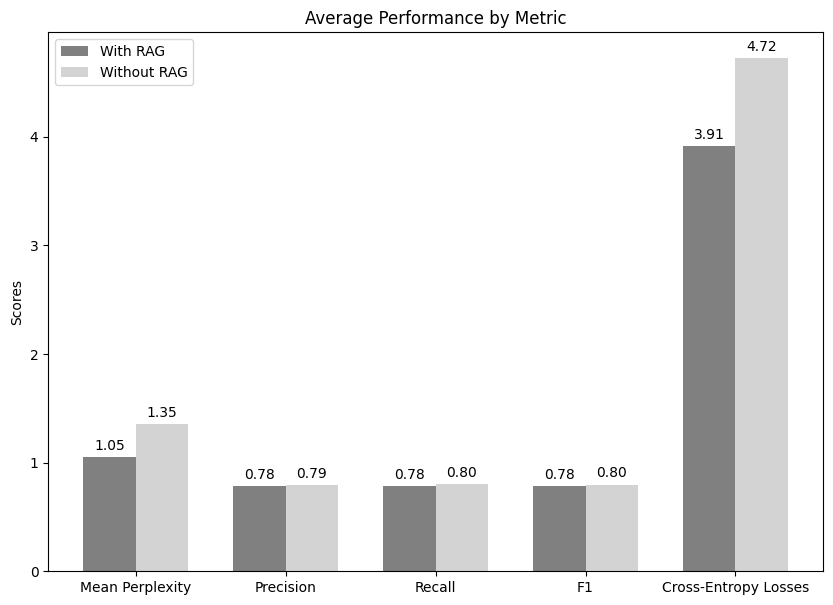

In [388]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_performance(rag_results, without_rag_results, metrics):
    """
    Plots average performance metrics for two models, with mean values annotated.

    :param rag_results: List of lists with performance metrics for the first model.
    :param without_rag_results: List of lists with performance metrics for the second model.
    :param metrics: List of metric names.
    """
    rag_results = np.array(rag_results)
    without_rag_results = np.array(without_rag_results)

    # Calculate the mean for each metric
    rag_means = np.mean(rag_results, axis=0)
    without_rag_means = np.mean(without_rag_results, axis=0)

    # Creating the plot
    fig, ax = plt.subplots(figsize=(10, 7))
    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars

    # Plotting the mean metrics for each model
    rects1 = ax.bar(x - width/2, rag_means, width, label='With RAG ', color='gray')
    rects2 = ax.bar(x + width/2, without_rag_means, width, label='Without RAG', color='lightgray')

    # Function to attach a text label above each bar
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Average Performance by Metric')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.show()


metrics = ["Mean Perplexity", "Precision", "Recall", "F1", "Cross-Entropy Losses"]
plot_average_performance(n_RAG_result, n_no_RAG_result, metrics)
#gpt-2-xl


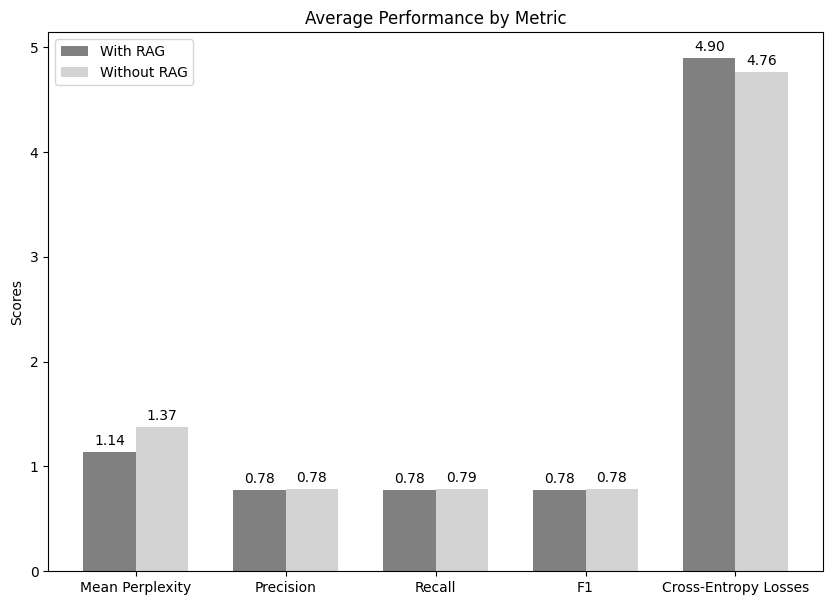

In [389]:
plot_average_performance(RAG_result, no_RAG_result, metrics)

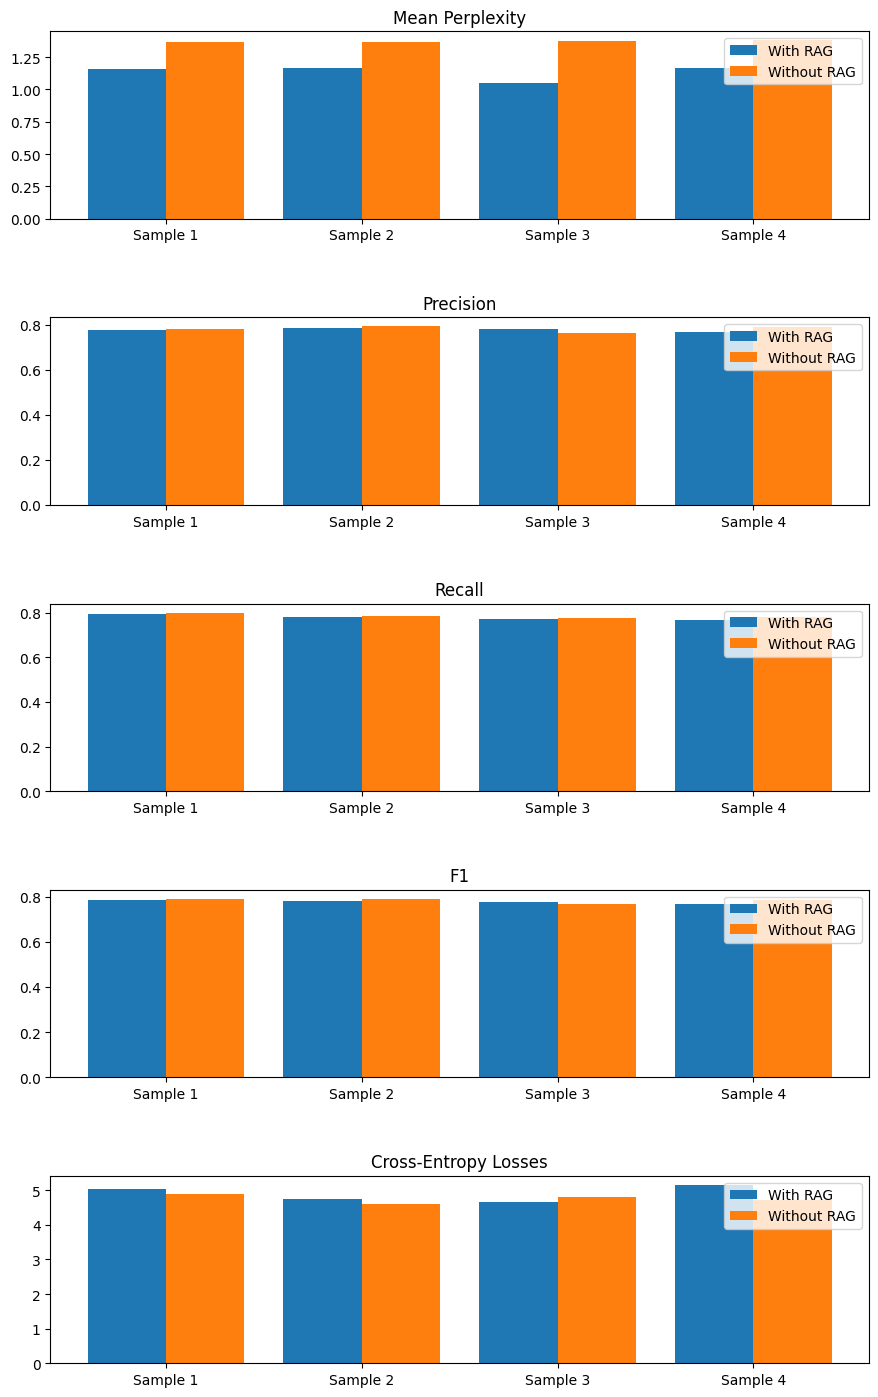

In [365]:
import matplotlib.pyplot as plt
import numpy as np

def plot_performance(rag_results, without_rag_results, metrics):
    """
    Plots the performance of two models on various metrics.

    :param rag_results: List of lists with performance metrics for the first model.
    :param without_rag_results: List of lists with performance metrics for the second model.
    :param metrics: List of metric names.
    """
    rag_results = np.array(rag_results)
    without_rag_results = np.array(without_rag_results)

    num_metrics = len(metrics)
    fig, axs = plt.subplots(num_metrics, 1, figsize=(10, num_metrics * 3))
    fig.tight_layout(pad=5.0)

    for i in range(num_metrics):
        axs[i].bar(np.arange(len(rag_results)) - 0.2, rag_results[:,i], width=0.4, label='With RAG')
        axs[i].bar(np.arange(len(without_rag_results)) + 0.2, without_rag_results[:,i], width=0.4, label='Without RAG')
        axs[i].set_title(metrics[i])
        axs[i].set_xticks(np.arange(len(rag_results)))
        axs[i].set_xticklabels([f'Sample {j+1}' for j in range(len(rag_results))])
        axs[i].legend()

    plt.show()

# Example usage
rag_results = [
    # Your data here...
]

without_rag_results = [
    # Your data here...
]

metrics = ["Mean Perplexity", "Precision", "Recall", "F1", "Cross-Entropy Losses"]
plot_performance(RAG_result, no_RAG_result, metrics)


In [ ]:
[1.0431250929832458, 0.785703718662262, 0.7405619025230408, 0.7624260485172272, 4.65403151512146]
[1.3573855757713318, 0.7761377394199371, 0.7630913257598877, 0.7695581018924713, 4.410228967666626]


In [ ]:
no_RAG_result = evaluation(
        gpt2_model,
        gpt2_tokenizer,
        tr_set,
        bert_tokenizer,
        bert_model,
        RAG = False,
        alpha = 1)
print(no_RAG_result)

. Based on that, tell me what/who is Urbanism?
generated text is 

Urbanism is a term that has been around for a long time. It is a term that has been around for a long time. It is a term that has been around for a long time. It is a term that has been around for a long time. It is a term that has been around for a long time. It is a term that has been around for a long time. It is a term that has been around for a long time. It is a term that has been around for a long time. It is a term that has been around for a long time. It is a term that has been around for a long time. It is a term that has been around for a long time. It is a term that has been around for a long time. It is a term that has been around for a long time. It is a term that has been around for a long time. It
. Based on that, tell me what/who is Mansur Al-Hallaj?
generated text is 

Mansur Al-Hallaj is a Muslim cleric who has been in jail for more than a decade. He is a member of the Islamic Society of North America

### different top K

In [ ]:
for top_k in [1, 5, 10]:
    RAG_result = evaluation(
        gpt2_model,
        gpt2_tokenizer,
        tr_set,
        bert_tokenizer,
        bert_model,
        RAG = True,
        alpha = 1,
        top_k = top_k
        )
    print(f"for k = {k}, result is {RAG_result}")

In [402]:
k_RAG_result=[]
k5_RAG_result=[]
k10_RAG_result=[]
for i in range(1):
    print(len(k_RAG_result))
    s = wikipedia_tr.select(random_indices_from_ranges([(0, 50000)], 2))
    print("小k")
    k_RAG_result.append(evaluation(
            gpt2_model,
            gpt2_tokenizer,
            s,
            bert_tokenizer,
            bert_model,
            RAG = True,
            alpha = 1,
            top_k=1
            ))
    print("中k")
    k5_RAG_result.append(evaluation(
        gpt2_model,
        gpt2_tokenizer,
        s,
        bert_tokenizer,
        bert_model,
        RAG = False,
        alpha = 1,
        top_k = 10
        ))
    print("大k")
    k10_RAG_result.append(evaluation(
        gpt2_model,
        gpt2_tokenizer,
        s,
        bert_tokenizer,
        bert_model,
        RAG = False,
        alpha = 1,
        top_k = 20
        ))
    print(k10_RAG_result[-1])
    print(k_RAG_result[-1])

0
小k


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

before summarize text is doctrine of ma'at is represented in the declarations to rekhti - merti - f - ent - ma'at and the 42 negative affirmations listed in the papyrus of ani : declarations to rekhti - merti - f - ent - ma'at verily i have come to thee, i have brought to thee ma'at. 1. 2 i have not done iniquity to mankind. 3 not have i done harm unto animals. 4 not have i done wickedness in the place of ma'at. 5 not have i known evil. 6 not have i acted wickedly. 7 not have i done each day and every works above what i should do. 8 not hath come forth my name to the boat of the prince. 9 not have i despised god. 10 not have i caused misery. 11 not have i caused affliction. 12 not have i done what is abominable to god. 13 not have i caused harm to be done to the servant by his chief. 14 not have i caused pain. 15 not have i made to weep. 16 not have i killed. 17 not have i made the order for killing for me. 18 not have i done harm to mankind. 19 not have i taken aught of the oblations 

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

before summarize text is messina ( ; ) is a province in the autonomous region of sicily. m" the waste land " is a poem by t. s eliot it was first published in 1922 after it had been printed in london in the criterion, it was reprinted in new york in the dial then it was published in the form of a book the poem is dedicated to ezra pound, whom t. s eliot regarded as his friend and teacher of poetry ezra pound was the first reader of the poem he helped eliot to make it shorter and better. the poem is divided into five parts they are : the burial of the dead, a game of chess, the fire sermon, death by water and what the thunder said it is composed of 433 lines the work is written in free verse and blank verse. the poem is full of quotations from classic works of world literature eliot makes allusions to geoffrey chaucer, william shakespeare, oliver goldsmith, ovid, charles baudelaire, gerard de nerval and thomas kyd he uses different sources of inspiration, including both christianity and

In [398]:
print(k_RAG_result, k10_RAG_result)

[[1.0356072187423706, 0.8005906939506531, 0.7697931528091431, 0.7848733365535736, 3.9143199920654297]] [[1.2812764644622803, 0.8246553540229797, 0.7918257415294647, 0.8079068660736084, 3.9460971355438232]]


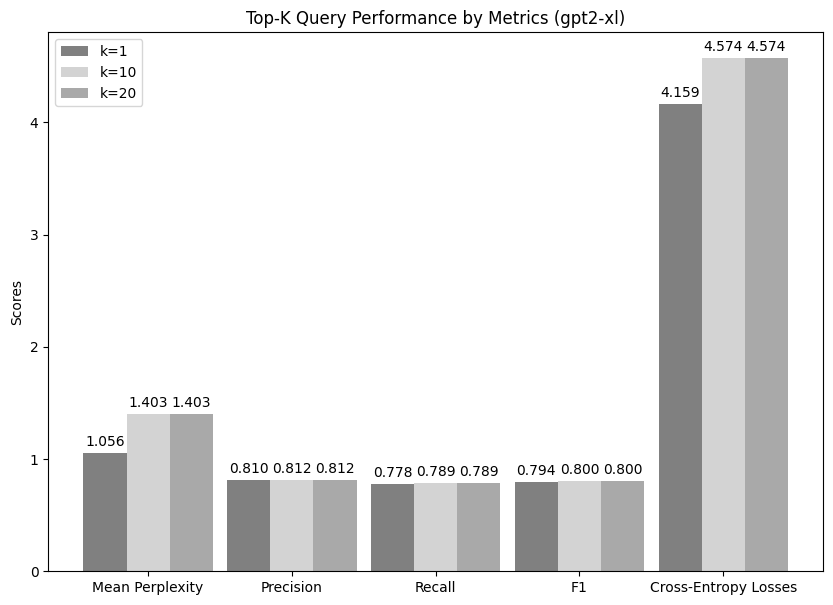

In [420]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_performance(rag_results, without_rag_results, additional_results, metrics):
    """
    Plots average performance metrics for three models, with mean values annotated.

    :param rag_results: List of lists with performance metrics for the first model.
    :param without_rag_results: List of lists with performance metrics for the second model.
    :param additional_results: List of lists with performance metrics for the third model.
    :param metrics: List of metric names.
    """
    rag_results = np.array(rag_results)
    without_rag_results = np.array(without_rag_results)
    additional_results = np.array(additional_results)

    # Calculate the mean for each metric
    rag_means = np.mean(rag_results, axis=0)
    without_rag_means = np.mean(without_rag_results, axis=0)
    additional_means = np.mean(additional_results, axis=0)

    # Creating the plot
    fig, ax = plt.subplots(figsize=(10,7))  # Making the figure square
    x = np.arange(len(metrics))  # the label locations
    width = 0.9  # the width of the bars
    offset = width / 3

    # Plotting the mean metrics for each model
    rects1 = ax.bar(x - offset, rag_means, width/3, label='k=1', color='gray')
    rects2 = ax.bar(x, without_rag_means, width/3, label='k=10', color='lightgray')
    rects3 = ax.bar(x + offset, additional_means, width/3, label='k=20', color='darkgray')

    # Function to attach a text label above each bar
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Top-K Query Performance by Metrics (gpt2-xl)')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.show()



metrics = ["Mean Perplexity", "Precision", "Recall", "F1", "Cross-Entropy Losses"]
plot_average_performance(k_RAG_result, k5_RAG_result, k10_RAG_result, metrics)

In [412]:
print(k10_RAG_result)
print(k5_RAG_result)
print(k_RAG_result)

[[1.4031818509101868, 0.8117315471172333, 0.7889891266822815, 0.8001701235771179, 4.573997259140015]]
[[1.4031818509101868, 0.8117315471172333, 0.7889891266822815, 0.8001701235771179, 4.573997259140015]]
[[1.0560563206672668, 0.8100432455539703, 0.7781618237495422, 0.793592631816864, 4.159182906150818]]


In [401]:
# print(k_RAG_result)
# print(k10_RAG_result)
# [[1.0356072187423706, 0.8005906939506531, 0.7697931528091431, 0.7848733365535736, 3.9143199920654297]]
# [[1.2812764644622803, 0.8246553540229797, 0.7918257415294647, 0.8079068660736084, 3.9460971355438232]]

[[1.0356072187423706, 0.8005906939506531, 0.7697931528091431, 0.7848733365535736, 3.9143199920654297]]
[[1.2812764644622803, 0.8246553540229797, 0.7918257415294647, 0.8079068660736084, 3.9460971355438232]]
